**This notebook is an exercise in the [Time Series](https://www.kaggle.com/learn/time-series) course.  You can reference the tutorial at [this link](https://www.kaggle.com/ryanholbrook/linear-regression-with-time-series).**

---


In [4]:
!python.exe -m pip install --upgrade pip
!pip install learntools
!pip install seaborn

In [12]:
import numpy as np
import pandas as pd


def fourier_features(index, freq, order):
    time = np.arange(len(index), dtype=np.float32)
    k = 2 * np.pi * (1 / freq) * time
  
   
    features = {}
    for i in range(1, order + 1):
        print(np.sin(i * k))
        features.update({
            f"sin_{freq}_{i}": np.sin(i * k),
            f"cos_{freq}_{i}": np.cos(i * k),
        })
    return pd.DataFrame(features, index=index)


# Compute Fourier features to the 4th order (8 new features) for a
# series y with daily observations and annual seasonality:
#
fourier_features([100,101,102], freq=365.25, order=4)

[0.         0.01720158 0.03439806]
[0.         0.03439806 0.06875541]
[0.         0.05158437 0.10303138]
[0.         0.06875541 0.13718541]


,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4
100,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
101,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634
102,0.034398,0.999408,0.068755,0.997634,0.103031,0.994678,0.137185,0.990545


# Introduction #

Run this cell to set everything up!

In [1]:
# Setup feedback system
from learntools.core import binder
binder.bind(globals())
from learntools.time_series.ex1 import *

# Setup notebook
from pathlib import Path
from learntools.time_series.style import *  # plot style settings

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression


data_dir = Path('../input/ts-course-data/')
comp_dir = Path('../input/store-sales-time-series-forecasting')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1) # parse_date to group date by date
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

C:\Users\Qunnie\anaconda3\envs\ml\lib\site-packages\learntools-0.3.4-py3.10.egg\learntools\time_series\checking_utils.py:16: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.


--------------------------------------------------------------------------------

One advantage linear regression has over more complicated algorithms is that the models it creates are *explainable* -- it's easy to interpret what contribution each feature makes to the predictions. In the model `target = weight * feature + bias`, the `weight` tells you by how much the `target` changes on average for each unit of change in the `feature`.

Run the next cell to see a linear regression on *Hardcover Sales*.

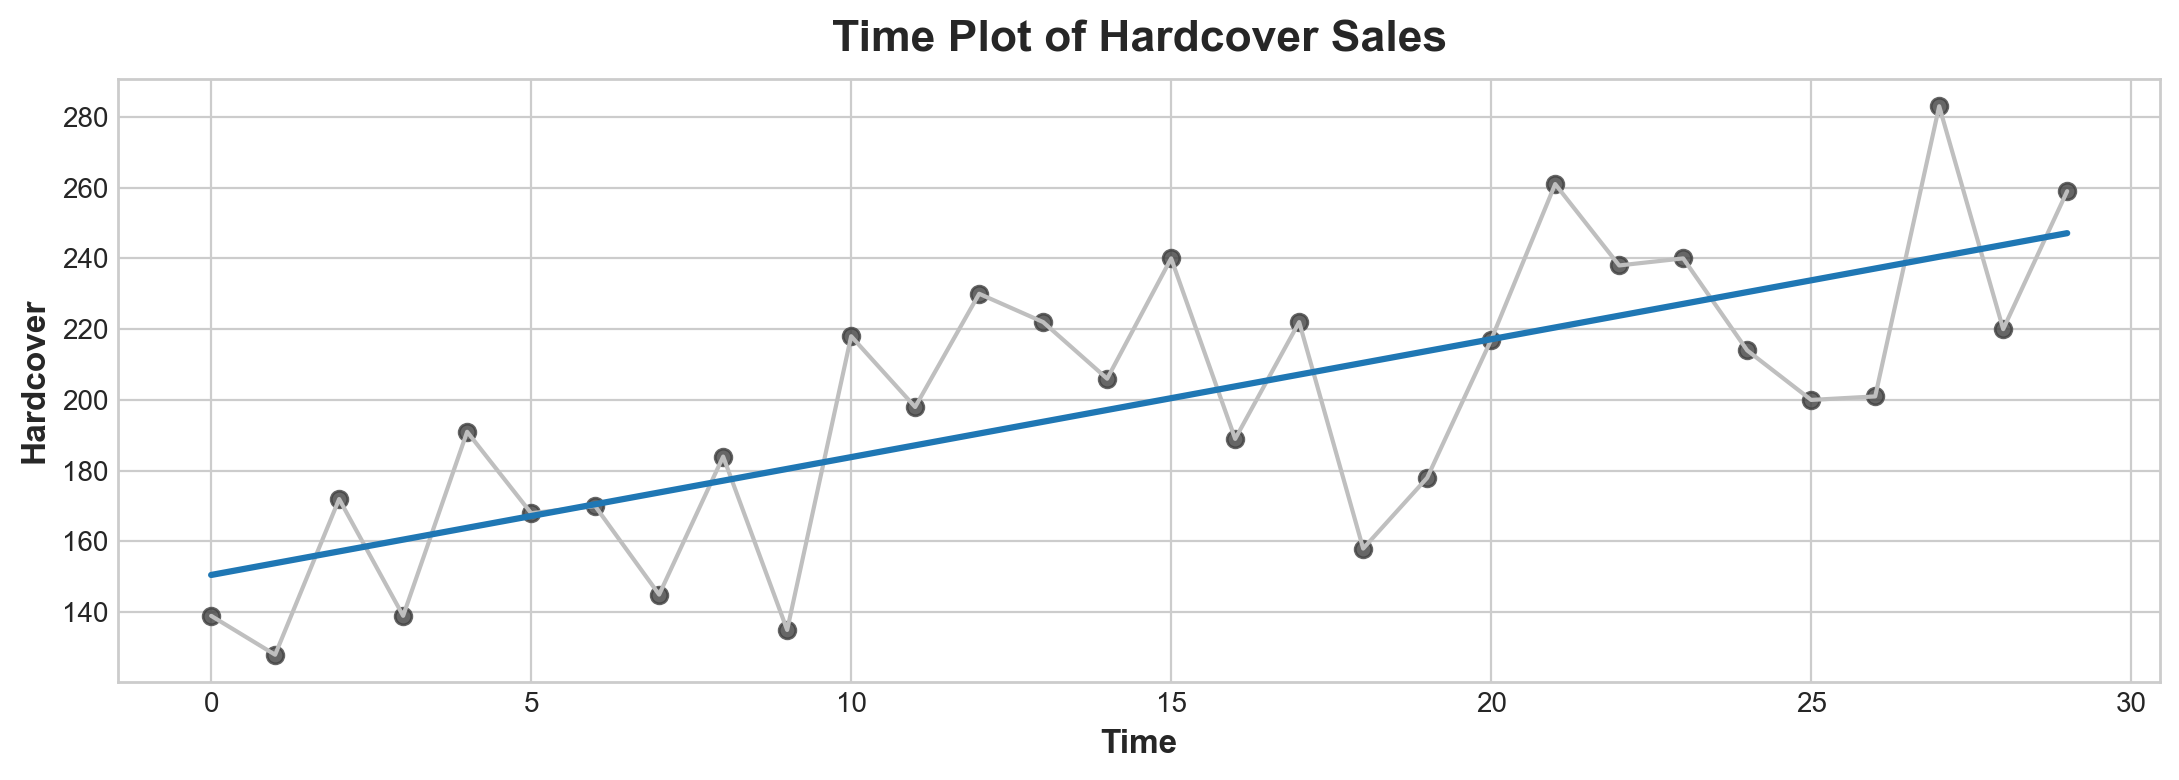

In [2]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

# 1) Interpret linear regression with the time dummy

The linear regression line has an equation of (approximately) `Hardcover = 3.33 * Time + 150.5`. Over 6 days how much on average would you expect hardcover sales to change? After you've thought about it, run the next cell.

Text(0.5, 1.0, 'Time Plot of Handcover')

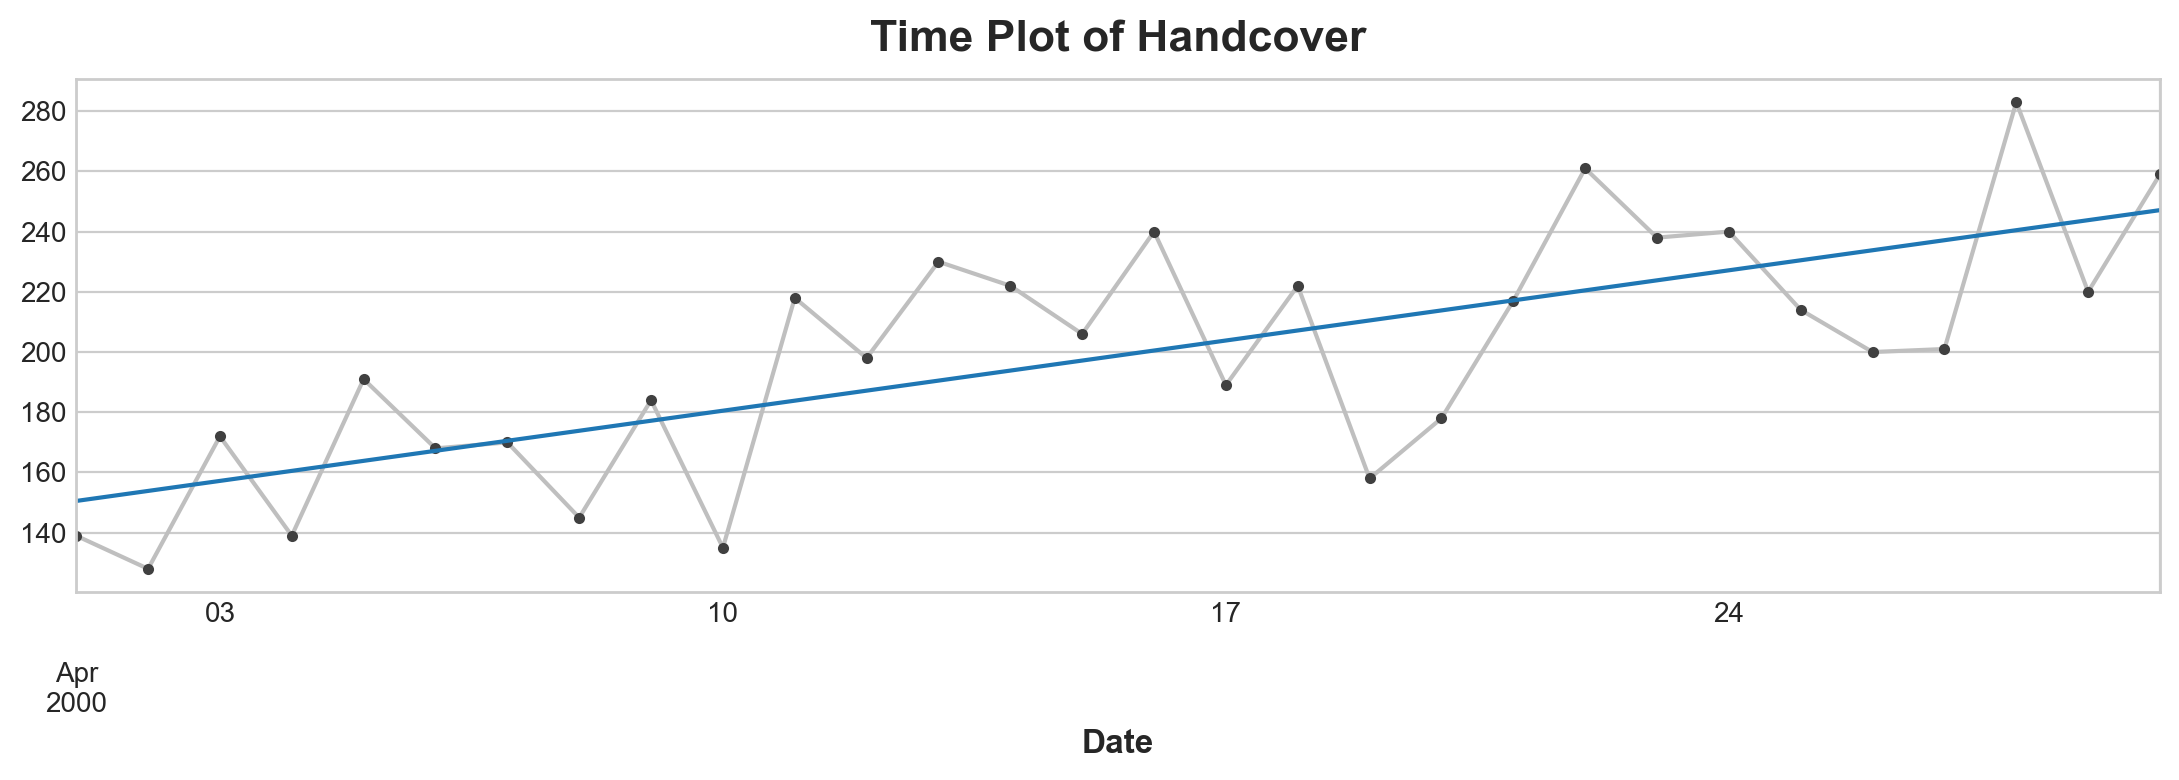

In [3]:
from sklearn.linear_model import LinearRegression

# Training data
X = book_sales.loc[:, ['Time']]  # features
y = book_sales.loc[:, 'Hardcover']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

# plotting data
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

ax = y.plot(**plot_params)
ax = y_pred.plot(ax=ax)
ax.set_title('Time Plot of Handcover')

In [9]:
# View the solution (Run this line to receive credit!)
q_1.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

A change of 6 steps in `Time` corresponds to an average change of 6 * 3.33 = 19.98 in `Hardcover` sales.


In [10]:
# Uncomment the next line for a hint
q_1.hint()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> Do you remember the slope-intercept equation of a line? The slope is 3.33, so `Hardcover` will change on average by 3.33 units for every 1 step change in `Time`, according to this model.


-------------------------------------------------------------------------------

Interpreting the regression coefficients can help us recognize serial dependence in a time plot. Consider the model `target = weight * lag_1 + error`, where `error` is random noise and `weight` is a number between -1 and 1. The `weight` in this case tells you how likely the next time step will have the same sign as the previous time step: a `weight` close to 1 means `target` will likely have the same sign as the previous step, while a `weight` close to -1 means `target` will likely have the opposite sign.

# 2) Interpret linear regression with a lag feature

Run the following cell to see two series generated according to the model just described.

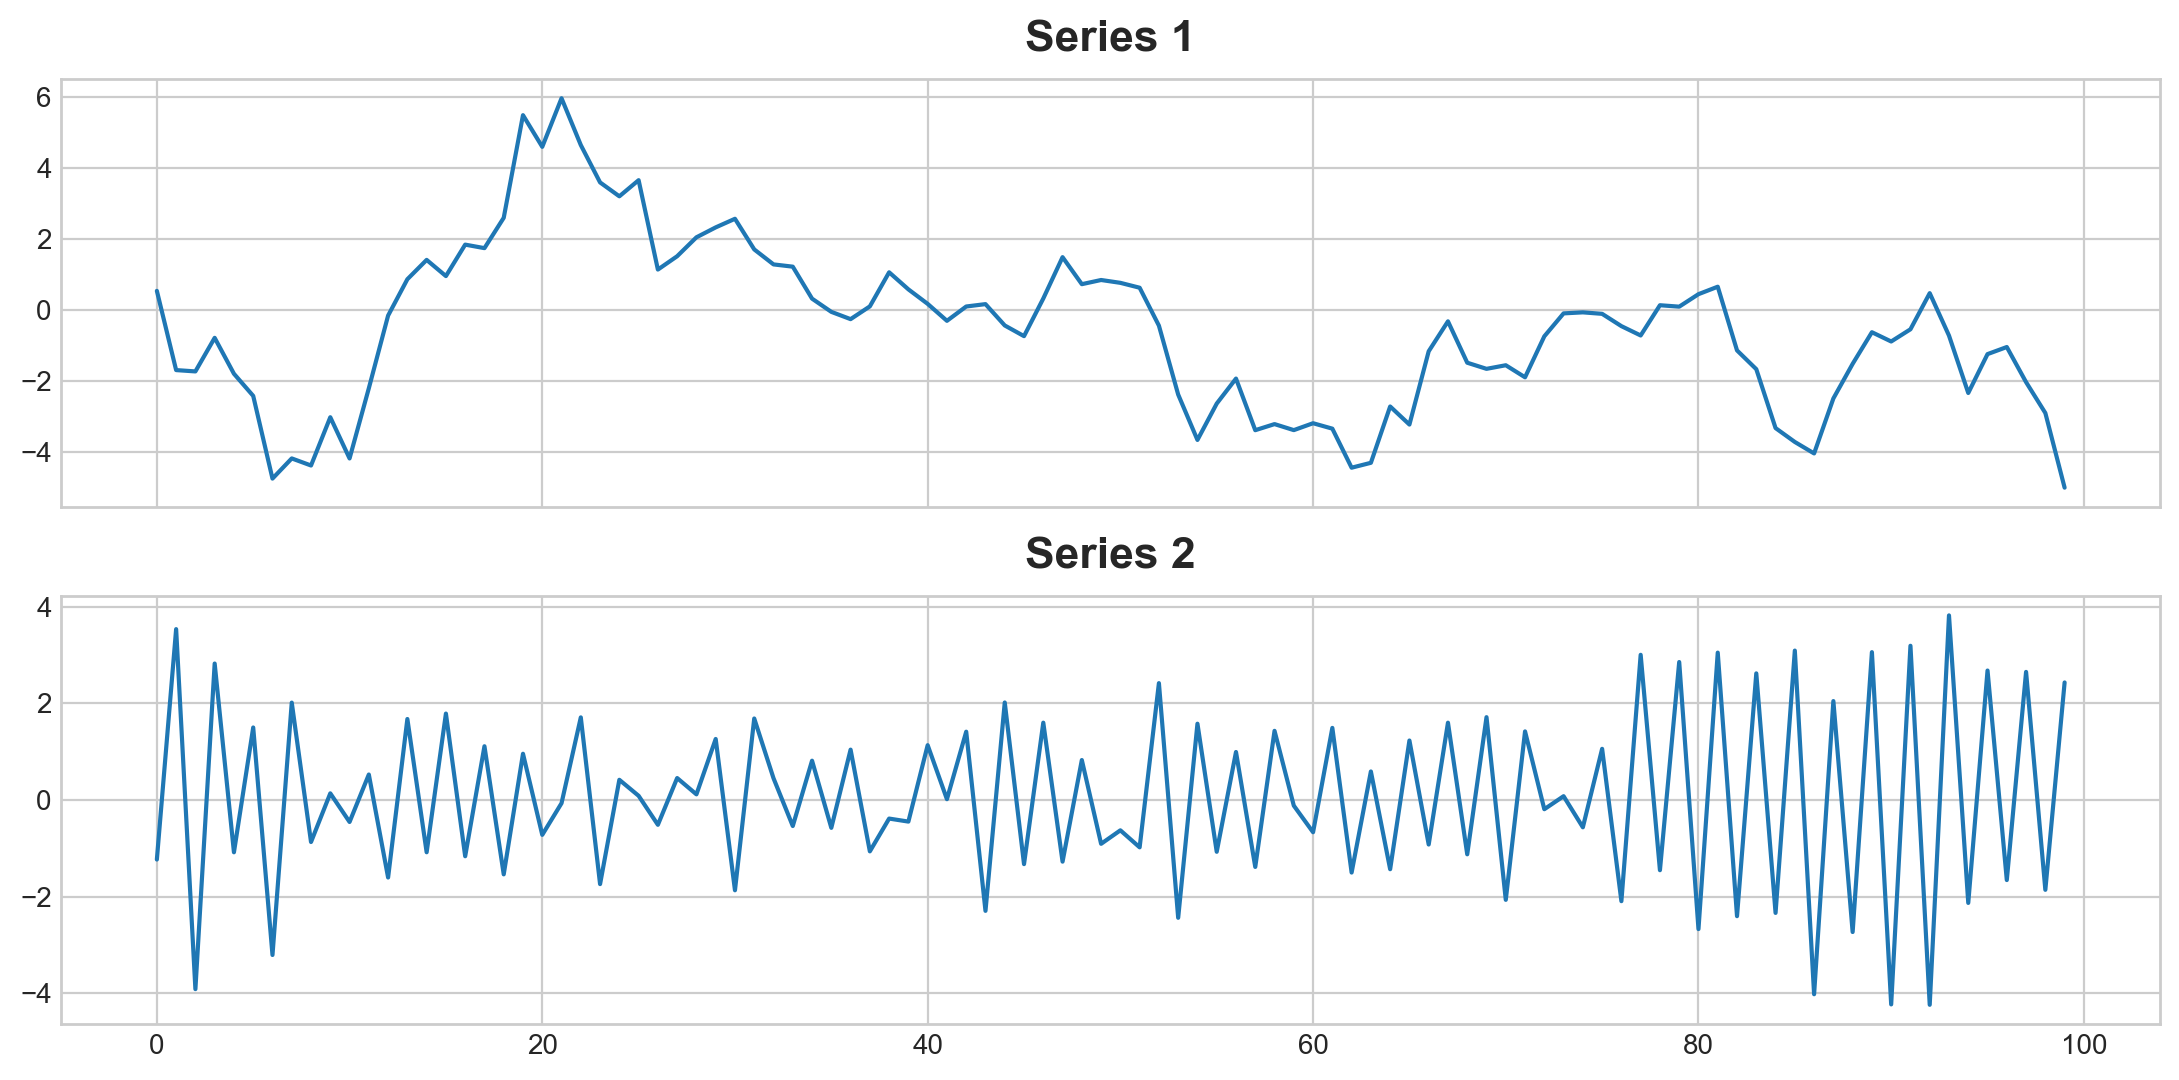

In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

In [5]:
print(ar.head())
ar1 = ar[['ar1','ar2']]
ar1['Lag'] = ar1['ar1'].shift(1)
print(ar1.head())

        ar1       ar2
0  0.541286 -1.234475
1 -1.692950  3.532498
2 -1.730106 -3.915508
3 -0.783524  2.820841
4 -1.796207 -1.084120
        ar1       ar2       Lag
0  0.541286 -1.234475       NaN
1 -1.692950  3.532498  0.541286
2 -1.730106 -3.915508 -1.692950
3 -0.783524  2.820841 -1.730106
4 -1.796207 -1.084120 -0.783524


[0.91704129]
[-0.89209364]


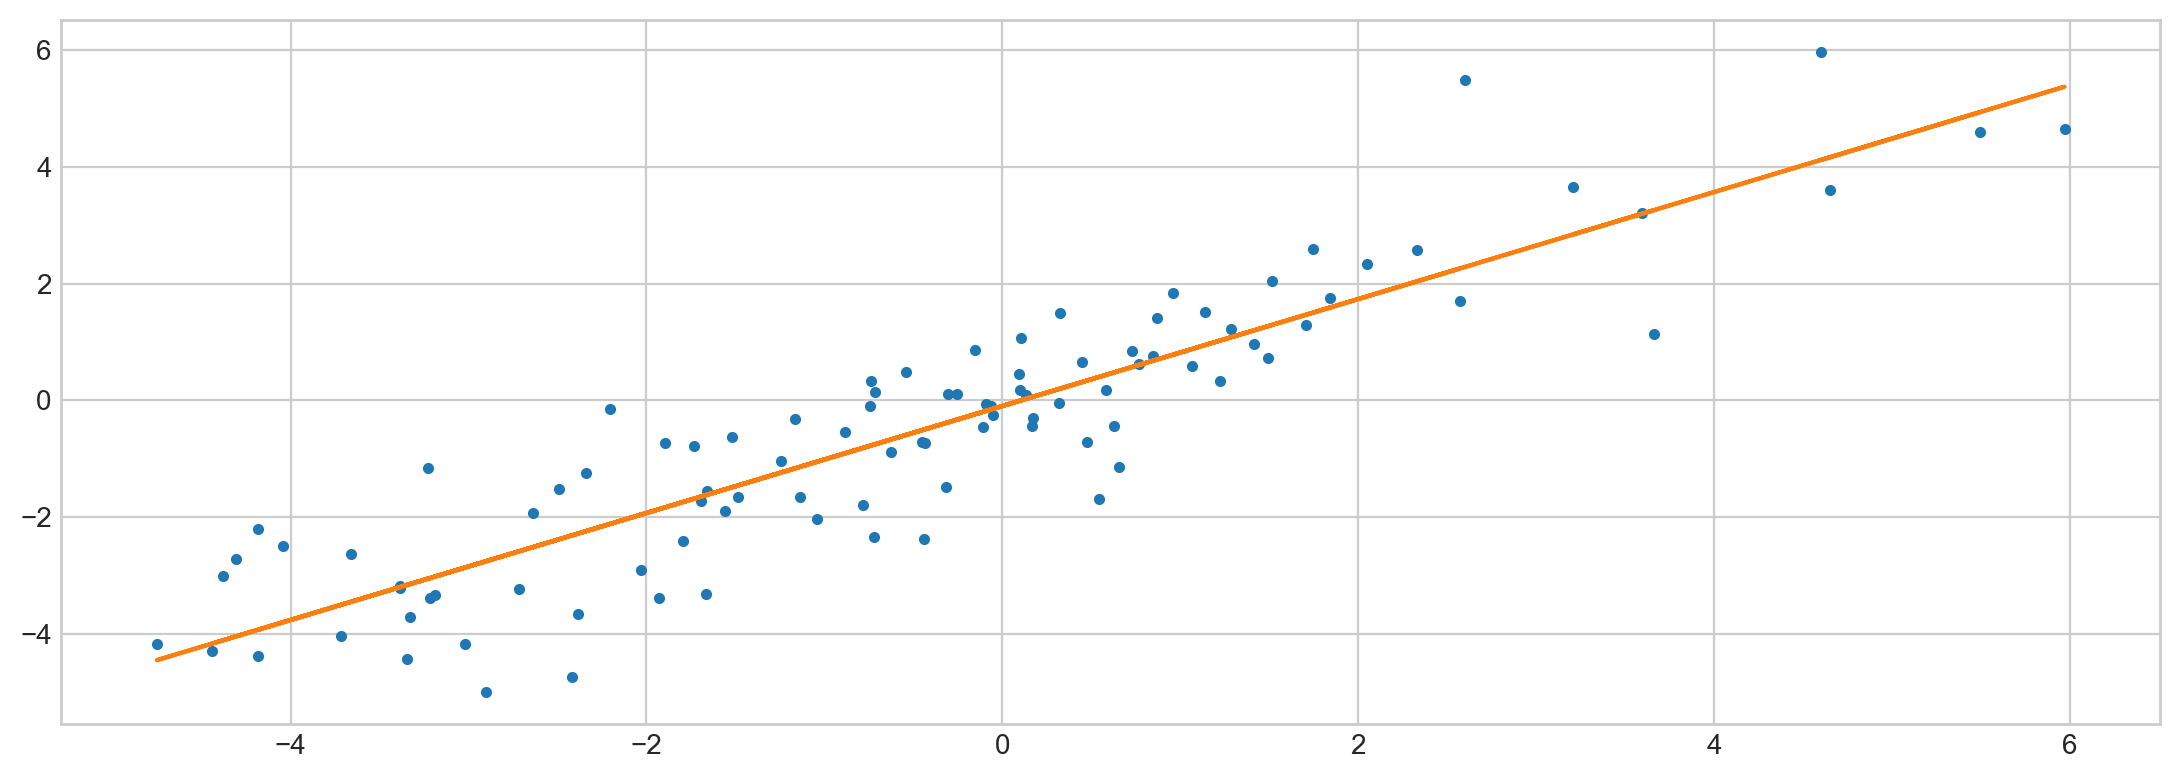

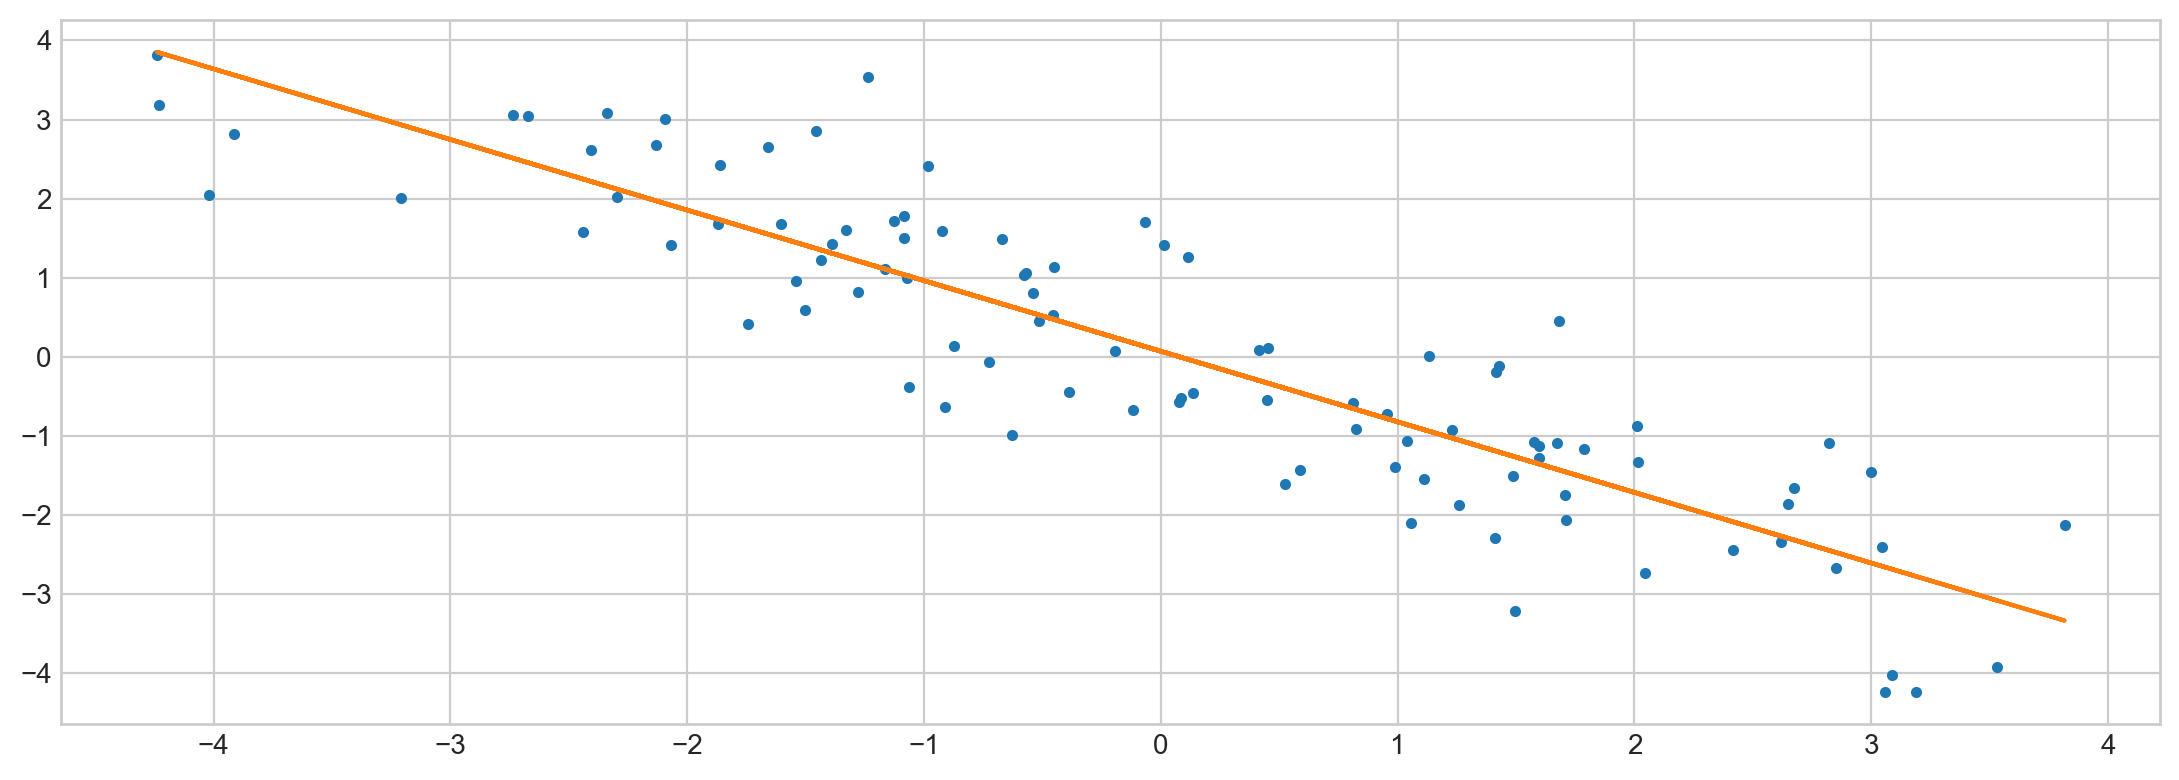

In [6]:
from sklearn.linear_model import LinearRegression

# Training data

# X = book_sales.loc[:, ['Time']]  # features
# y = book_sales.loc[:, 'Hardcover']  # target

# Train the model
ar1 = ar[['ar1']]
ar1['Lag'] = ar1['ar1'].shift(1)
ar1.head()

X = ar1.loc[:,['Lag']] # feature so must array ( bounded by [] to declare arrray as multiple features)
X.dropna(inplace = True)
Y = ar1.loc[:,'ar1'] # targert so must be single value (Not bounded by [] to declare arrray as multiple features)
Y, X = Y.align(X, join='inner')

model = LinearRegression()
model.fit(X,Y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['Lag'], Y, '.')
ax.plot(X['Lag'], y_pred)

print(model.coef_)

# Train the model
ar2 = ar[['ar2']]
ar2['Lag'] = ar2['ar2'].shift(1)
ar2.head()

X = ar2.loc[:,['Lag']] # feature so must array ( bounded by [] to declare arrray as multiple features)
X.dropna(inplace = True)
Y = ar2.loc[:,'ar2'] # targert so must be single value (Not bounded by [] to declare arrray as multiple features)
Y, X = Y.align(X, join='inner')

model = LinearRegression()
model.fit(X,Y)

y_pred = pd.Series(model.predict(X), index=X.index)

fig, ax = plt.subplots()
ax.plot(X['Lag'], Y, '.')
ax.plot(X['Lag'], y_pred)

print(model.coef_)


One of these series has the equation `target = 0.95 * lag_1 + error` and the other has the equation `target = -0.95 * lag_1 + error`, differing only by the sign on the lag feature. Can you tell which equation goes with each series?

In [65]:
# View the solution (Run this cell to receive credit!)
q_2.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct:</span> 

**Series 1** was generated by `target = 0.95 * lag_1 + error` and **Series 2** was generated by `target = -0.95 * lag_1 + error`.


In [66]:
# Uncomment the next line for a hint
q_2.hint()

<IPython.core.display.Javascript object>

<span style="color:#3366cc">Hint:</span> The series with the 0.95 weight will tend to have values with signs that stay the same. The series with the -0.95 weight will tend to have values with signs that change back and forth.


-------------------------------------------------------------------------------

Now we'll get started with the *Store Sales - Time Series Forecasting* competition data. The entire dataset comprises almost 1800 series recording store sales across a variety of product families from 2013 into 2017. For this lesson, we'll just work with a single series (`average_sales`) of the average sales each day.

# 3) Fit a time-step feature

Complete the code below to create a linear regression model with a time-step feature on the series of average product sales. The target is in a column called `'sales'`.

In [48]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

In [52]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

# YOUR CODE HERE: Create a time dummy
time = np.arange(len(df.index)) 

df['time'] = time 

# YOUR CODE HERE: Create training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)


# Check your answer
q_3.check()

<IPython.core.display.Javascript object>

<span style="color:#33cc33">Correct</span>

In [ ]:
# Lines below will give you a hint or solution code
#q_3.hint()
#q_3.solution()

Run this cell if you'd like to see a plot of the result.

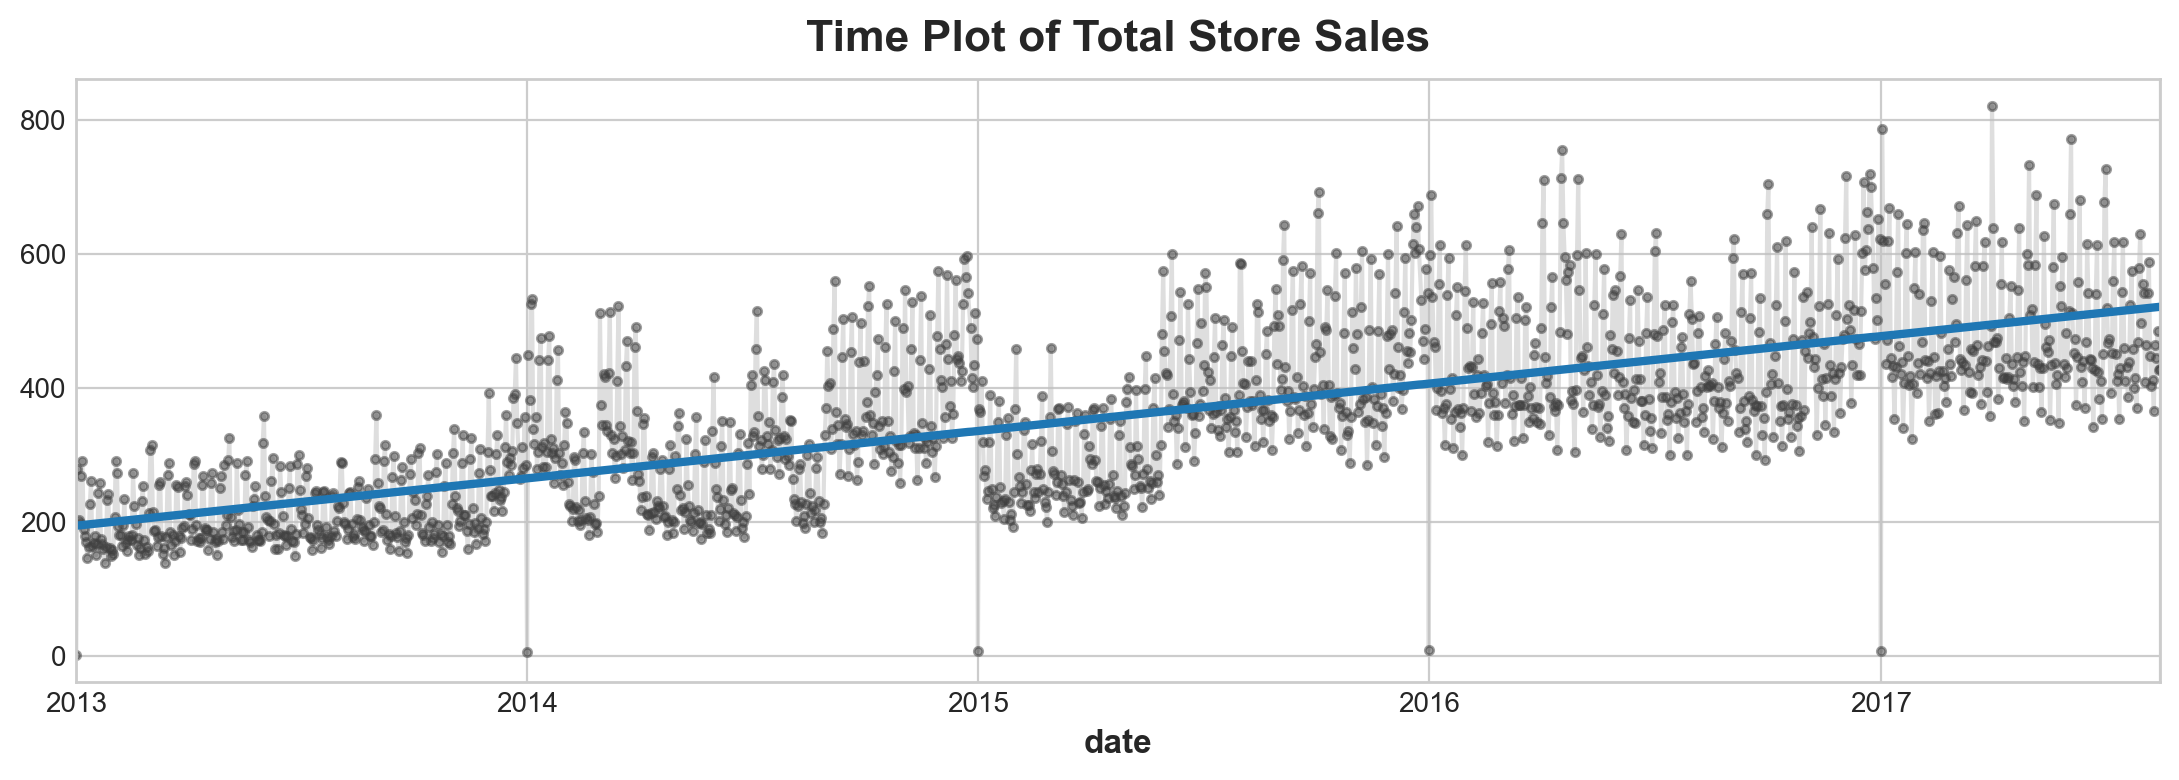

In [53]:
ax = y.plot(**plot_params, alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

-------------------------------------------------------------------------------

# 4) Fit a lag feature to Store Sales

Complete the code below to create a linear regression model with a lag feature on the series of average product sales. The target is in a column of `df` called `'sales'`.

In [62]:
df = average_sales.to_frame()
lag_1 = df['sales'].shift(1)
lag_1

date
2013-01-01           NaN
2013-01-02      1.409438
2013-01-03    278.390808
2013-01-04    202.840195
2013-01-05    198.911163
                 ...    
2017-08-11    365.536987
2017-08-12    463.733856
2017-08-13    444.798309
2017-08-14    485.768616
2017-08-15    427.004730
Freq: D, Name: sales, Length: 1684, dtype: float32

In [72]:
df = average_sales.to_frame()

# YOUR CODE HERE: Create a lag feature from the target 'sales'
lag_1 = df['sales'].shift(1)

df['lag_1'] = lag_1  # add to dataframe

X = df.loc[:, ['lag_1']].dropna()  # features
y = df.loc[:, 'sales']  # target
y, X = y.align(X, join='inner')  # drop corresponding values in target

# YOUR CODE HERE: Create a LinearRegression instance and fit it to X and y.
model = LinearRegression()
model.fit(X, y)

# YOUR CODE HERE: Create Store the fitted values as a time series with
# the same time index as the training data
y_pred = pd.Series(model.predict(X),index=X.index) # model.predict return np.array
print(y_pred)


# Check your answer
#q_4.check()

0        85.301689
1       297.268250
2       239.451340
3       236.444550
4       289.219421
           ...    
1678    363.958893
1679    439.106384
1680    424.615509
1681    455.968994
1682    410.998535
Length: 1683, dtype: float32
date
2013-01-02     85.301689
2013-01-03    297.268250
2013-01-04    239.451340
2013-01-05    236.444550
2013-01-06    289.219421
                 ...    
2017-08-11    363.958893
2017-08-12    439.106384
2017-08-13    424.615509
2017-08-14    455.968994
2017-08-15    410.998535
Freq: D, Length: 1683, dtype: float32


In [ ]:
# Lines below will give you a hint or solution code
q_4.hint()
q_4.solution()

Run the next cell if you'd like to see the result.

In [ ]:
fig, ax = plt.subplots()
ax.plot(X['lag_1'], y, '.', color='0.25')
ax.plot(X['lag_1'], y_pred)
ax.set(aspect='equal', ylabel='sales', xlabel='lag_1', title='Lag Plot of Average Sales');

# Keep Going #

[**Model trend**](https://www.kaggle.com/ryanholbrook/trend) in time series with moving average plots and the time dummy.

---




*Have questions or comments? Visit the [course discussion forum](https://www.kaggle.com/learn/time-series/discussion) to chat with other learners.*